### Training of the NeuroSegNet on BraTS 2025 preprocessed dataset

In [1]:
# Imports & Setup
import os
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import json
from pathlib import Path
# Path
project_root = Path.cwd().parent  
src_path = project_root / "src"
sys.path.insert(0, str(project_root))
from glob import glob
from monai.data import load_decathlon_datalist
from monai.transforms import LoadImaged
from src.utils.config_loader import load_config
from src.models.neurosegnet import NeuroSegNet
from src.utils.helpers import set_seed, ensure_dir
from src.training.train_loop import train
from src.training.validation import evaluate
from src.data.dataloader import create_loader
from monai.transforms import Activations, AsDiscrete
from src.training.validation import evaluate
from src.training.loss import DiceFocalLoss

# Print device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cpu


In [2]:
# Load Configs
model_cfg = load_config(project_root / "configs/model/neurosegnet.yml")
data_cfg = load_config(project_root / "configs/data.yml")
train_cfg = load_config(project_root / "configs/train.yml")

# Set seed for reproducibility
set_seed(train_cfg["seed"])

In [3]:
data_dir = Path("C:/Users/user/NeuroSegNet/data/processed_stacked")
stacked_files = sorted(data_dir.glob("*.nii.gz"))

print(f"Total .nii.gz files found: {len(stacked_files)}")

# Check if empty
if len(stacked_files) == 0:
    raise RuntimeError("No training data found!")

# Split
val_split = 0.2
num_val = int(len(stacked_files) * val_split)
train_files = stacked_files[:-num_val]
val_files = stacked_files[-num_val:]

train_dicts = [{"image": str(f)} for f in train_files]
val_dicts = [{"image": str(f)} for f in val_files]

# Confirm
print(f"Training: {len(train_dicts)} files")
print(f"Validation: {len(val_dicts)} files")

# Create loaders
train_loader = create_loader(
    data_dicts=train_dicts,
    batch_size=train_cfg["batch_size"],
    num_workers=0,
    patch_size=data_cfg["patch_size"],
    is_train=True,
)

val_loader = create_loader(
    data_dicts=val_dicts,
    batch_size=1,
    num_workers=0,
    patch_size=data_cfg["patch_size"],
    is_train=False,
)

Total .nii.gz files found: 1246
Training: 997 files
Validation: 249 files


Raw shape: (128, 128, 128, 5)
Corrected shape (channel-first): (5, 128, 128, 128)


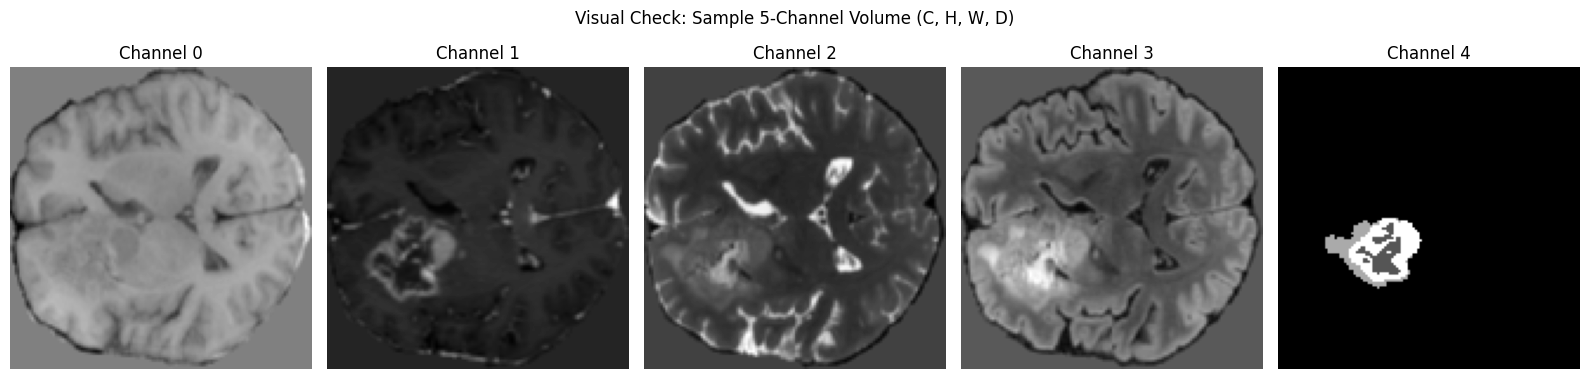

In [4]:
sample_nifti = nib.load(str(train_files[0]))
data = sample_nifti.get_fdata()
print(f"Raw shape: {data.shape}")  # Expecting (128, 128, 128, 5) instead of (5, H, W, D)

# Transpose to channel-first
data = np.transpose(data, (3, 0, 1, 2))  # (C, H, W, D)
print(f"Corrected shape (channel-first): {data.shape}")

# Plot center slices
center_slice = data.shape[-1] // 2
fig, axes = plt.subplots(1, data.shape[0], figsize=(16, 4))
for i in range(data.shape[0]):
    axes[i].imshow(data[i, :, :, center_slice], cmap="gray")
    axes[i].set_title(f"Channel {i}")
    axes[i].axis("off")
plt.suptitle("Visual Check: Sample 5-Channel Volume (C, H, W, D)")
plt.tight_layout()
plt.show()

In [5]:
# Initialize Model, Optimizer, Scheduler
model = NeuroSegNet({
    "model": model_cfg["model"],
    "cnn_encoder": model_cfg["cnn_encoder"],
    "transformer": model_cfg["transformer"],
    "fusion": model_cfg["fusion"],
    "decoder": model_cfg["decoder"],
}).to(DEVICE)

from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = AdamW(
    model.parameters(),
    lr=train_cfg["optimizer"]["lr"],
    weight_decay=train_cfg["optimizer"]["weight_decay"]
)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=True
)

In [ ]:
# We set Checkpoint Path and Train
checkpoint_dir = Path(r"C:\Users\user\NeuroSegNet\experiments\neurosegnet_v1\checkpoints")
checkpoint_dir.mkdir(parents=True, exist_ok=True)
train_cfg["checkpoint_path"] = str(checkpoint_dir/"best_model.pth")

train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    config=train_cfg,
    device=DEVICE,
)

In [1]:
# Final Evaluation on Validation Set
ckpt = torch.load(train_cfg["checkpoint_path"], map_location=DEVICE)
state_dict = ckpt["model_state_dict"] if "model_state_dict" in ckpt else ckpt
model.load_state_dict(state_dict, strict=False)
model.eval().to(DEVICE)

loss_fn = DiceFocalLoss(
    alpha=train_cfg["loss"]["focal_alpha"],
    gamma=train_cfg["loss"]["focal_gamma"],
    dice_weight=train_cfg["loss"]["lambda_dice"],
    focal_weight=train_cfg["loss"]["lambda_focal"]
)

metrics = evaluate(model, val_loader, loss_fn, device=DEVICE)
print(json.dumps(metrics, indent=2))


NameError: name 'torch' is not defined